In [245]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

import random
import os

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [158]:
# pip install optuna
# optuna.trial.Trial.suggest_categorical() : 리스트 범위 내에서 값을 선택한다.
# optuna.trial.Trial.suggest_int() : 범위 내에서 정수형 값을 선택한다.
# optuna.trial.Trial.suggest_float() : 범위 내에서 소수형 값을 선택한다.
# optuna.trial.Trial.suggest_uniform() : 범위 내에서 균일분포 값을 선택한다.
# optuna.trial.Trial.suggest_discrete_uniform() : 범위 내에서 이산 균일분포 값을 선택한다.
# optuna.trial.Trial.suggest_loguniform() : 범위 내에서 로그 함수 값을 선택한다.

In [159]:
path= '/opt/ml/level1_bookratingprediction_recsys-level1-recsys-06/data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


In [160]:
def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)


# 전처리

In [161]:
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0])
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1])
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2])
users = users.drop(['location'], axis=1)

In [162]:
ratings = pd.concat([train_ratings, test_ratings]).reset_index(drop=True)
context_df = ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
train_df = train_ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
test_df = test_ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')

In [163]:
loc_city2idx = {v:k for k,v in enumerate(context_df['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(context_df['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(context_df['location_country'].unique())}

In [164]:
train_df['location_city'] = train_df['location_city'].map(loc_city2idx)
train_df['location_state'] = train_df['location_state'].map(loc_state2idx)
train_df['location_country'] = train_df['location_country'].map(loc_country2idx)

test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
test_df['location_country'] = test_df['location_country'].map(loc_country2idx)

In [165]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

In [166]:
train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
train_df['age'] = train_df['age'].apply(age_map)
test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
test_df['age'] = test_df['age'].apply(age_map)

In [167]:
category2idx = {v:k for k,v in enumerate(context_df['category'].unique())}
publisher2idx = {v:k for k,v in enumerate(context_df['publisher'].unique())}
language2idx = {v:k for k,v in enumerate(context_df['language'].unique())}
author2idx = {v:k for k,v in enumerate(context_df['book_author'].unique())}

In [168]:
train_df['category'] = train_df['category'].map(category2idx)
train_df['publisher'] = train_df['publisher'].map(publisher2idx)
train_df['language'] = train_df['language'].map(language2idx)
train_df['book_author'] = train_df['book_author'].map(author2idx)

test_df['category'] = test_df['category'].map(category2idx)
test_df['publisher'] = test_df['publisher'].map(publisher2idx)
test_df['language'] = test_df['language'].map(language2idx)
test_df['book_author'] = test_df['book_author'].map(author2idx)

In [169]:
train_df['id'] = train_df['user_id'].copy()
test_df['id'] = test_df['user_id'].copy()

train_df['bn'] = train_df['isbn'].copy()
test_df['bn'] = test_df['isbn'].copy()

In [170]:
for i in enumerate (list(train_df.columns)) :
    ca = i[1]
    train_df[ca] = train_df[ca].astype('str')
    test_df[ca] = test_df[ca].astype('str')
train_df['rating'] = train_df['rating'].astype('float64')
test_df['rating'] = test_df['rating'].astype('float64')

train_df['age'] = train_df['age'].astype('float64')
test_df['age'] = test_df['age'].astype('float64')

1. age는 범위가 좁기도 하고 str으로 해서 label encoding이 비효율적이라 판단 ! -> 실제로 범위도 작기 때문에 age는 수치형으로 판단하는게 분석적으로 봤을 때 더 모델 성능에 좋은 결과를 미칠 것 이라 판단
2. catb의 수치형 모델 알고리즘은 기존의 부스팅 모델들의 알고리즘과 같이 tree로 이루어짐 

In [171]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76699 entries, 0 to 76698
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           76699 non-null  object 
 1   isbn              76699 non-null  object 
 2   rating            76699 non-null  float64
 3   age               76699 non-null  float64
 4   location_city     76699 non-null  object 
 5   location_state    76699 non-null  object 
 6   location_country  76699 non-null  object 
 7   category          76699 non-null  object 
 8   publisher         76699 non-null  object 
 9   language          76699 non-null  object 
 10  book_author       76699 non-null  object 
 11  id                76699 non-null  object 
 12  bn                76699 non-null  object 
dtypes: float64(2), object(11)
memory usage: 8.2+ MB


In [172]:
for col in train_df.columns:
    print(f'{col} 범주 수: {train_df[col].nunique()}')

user_id 범주 수: 59803
isbn 범주 수: 129777
rating 범주 수: 10
age 범주 수: 6
location_city 범주 수: 11374
location_state 범주 수: 1487
location_country 범주 수: 318
category 범주 수: 3873
publisher 범주 수: 10408
language 범주 수: 25
book_author 범주 수: 54716
id 범주 수: 59803
bn 범주 수: 129777


In [173]:
type(list(train_df.drop(['rating','user_id','isbn'], axis =1).columns)[0])

str

# 모델링

## Optuna 함수 정의

In [195]:
def objective(trial):
  param = {
      
      "random_state":42,
      "objective" : "RMSE",
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }
  train_x, val_x, train_y, val_y = train_test_split(train_df.drop(['rating','user_id','isbn'], axis = 1), train_df['rating'], test_size=0.2)

  model = CatBoostRegressor(**param, task_type = 'GPU')
  model.fit(
      train_x,
      train_y,
      eval_set=[(val_x, val_y)],
      cat_features = list(train_df.drop(['age','rating','user_id','isbn'], axis =1).columns),
      verbose=100
  )

  cat_pred = model.predict(val_x)
  log_score = rmse(val_y, cat_pred)

  return log_score

In [196]:
# parameter 참고
# params_cat = {
#         "task_type" : "GPU",
#         "devices" : '0',
#         "random_state": SEED,
#         "learning_rate": 0.05,
#         "n_estimators": 2000,
#         "verbose" : 1,
#         "objective" : "RMSE",
#         "max_depth": 10,#trial.suggest_int("max_depth", 1, 16),
#         "colsample_bylevel": 1,#trial.suggest_float("colsample_bylevel", 0.8, 1.0),
#         #"subsample": 0.8, #trial.suggest_float("subsample", 0.3, 1.0), GPU 사용시 안될수도.
#         "min_child_samples": 50, #trial.suggest_int("min_child_samples", 5, 100),
#         "max_bin": 300, #trial.suggest_int("max_bin", 200, 500),
#         "cat_features" : list(train_df.drop(['age','rating','user_id','isbn'], axis =1).columns),
#         "one_hot_max_size" : 256
# }

## Optuna 활용한 모델 실행

In [197]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-10-29 06:35:17,382] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4320029	test: 2.4355332	best: 2.4355332 (0)	total: 13.3ms	remaining: 1m 40s
100:	learn: 2.4267088	test: 2.4293666	best: 2.4293666 (100)	total: 1.13s	remaining: 1m 23s
bestTest = 2.429362425
bestIteration = 170
Shrink model to first 171 iterations.


[I 2022-10-29 06:35:23,450] Trial 0 finished with value: 2.4293627866014256 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4293627866014256.


0:	learn: 2.4336202	test: 2.4309055	best: 2.4309055 (0)	total: 12.8ms	remaining: 1m 48s
100:	learn: 2.4283644	test: 2.4243908	best: 2.4243908 (100)	total: 1.1s	remaining: 1m 31s
200:	learn: 2.4277694	test: 2.4234933	best: 2.4234933 (200)	total: 2.2s	remaining: 1m 30s
300:	learn: 2.4277025	test: 2.4233383	best: 2.4233383 (300)	total: 3.3s	remaining: 1m 29s
400:	learn: 2.4276945	test: 2.4233028	best: 2.4233026 (399)	total: 4.4s	remaining: 1m 28s
500:	learn: 2.4276937	test: 2.4232923	best: 2.4232923 (500)	total: 5.52s	remaining: 1m 28s
600:	learn: 2.4276932	test: 2.4232895	best: 2.4232894 (595)	total: 6.61s	remaining: 1m 26s
700:	learn: 2.4276936	test: 2.4232886	best: 2.4232884 (695)	total: 7.71s	remaining: 1m 25s
800:	learn: 2.4276939	test: 2.4232881	best: 2.4232880 (785)	total: 8.79s	remaining: 1m 24s
900:	learn: 2.4276938	test: 2.4232881	best: 2.4232880 (785)	total: 9.89s	remaining: 1m 23s
1000:	learn: 2.4276938	test: 2.4232881	best: 2.4232880 (785)	total: 11s	remaining: 1m 22s
1100:	l

[I 2022-10-29 06:37:07,527] Trial 1 finished with value: 2.423288113205799 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.423288113205799.


0:	learn: 2.4060595	test: 2.4014849	best: 2.4014849 (0)	total: 33.1ms	remaining: 2m
100:	learn: 2.1873755	test: 2.1566879	best: 2.1566879 (100)	total: 2.79s	remaining: 1m 37s
200:	learn: 2.1644718	test: 2.1490083	best: 2.1490083 (200)	total: 5.36s	remaining: 1m 31s
300:	learn: 2.1461125	test: 2.1472575	best: 2.1472575 (300)	total: 7.84s	remaining: 1m 26s
400:	learn: 2.1307500	test: 2.1463107	best: 2.1462307 (394)	total: 10.4s	remaining: 1m 23s
500:	learn: 2.1173575	test: 2.1461277	best: 2.1457788 (431)	total: 12.9s	remaining: 1m 20s
600:	learn: 2.1036081	test: 2.1456186	best: 2.1455404 (596)	total: 15.4s	remaining: 1m 17s
700:	learn: 2.0909264	test: 2.1456178	best: 2.1453697 (620)	total: 17.9s	remaining: 1m 14s
800:	learn: 2.0784078	test: 2.1455520	best: 2.1453697 (620)	total: 20.4s	remaining: 1m 12s
900:	learn: 2.0669292	test: 2.1460309	best: 2.1453697 (620)	total: 23s	remaining: 1m 9s
1000:	learn: 2.0557220	test: 2.1467363	best: 2.1453697 (620)	total: 25.5s	remaining: 1m 6s
1100:	lea

[I 2022-10-29 06:38:45,448] Trial 2 finished with value: 2.145369597361437 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.145369597361437.


0:	learn: 2.3961448	test: 2.3994034	best: 2.3994034 (0)	total: 502ms	remaining: 13m 15s
100:	learn: 1.9868617	test: 2.1611062	best: 2.1610978 (99)	total: 46.5s	remaining: 11m 23s
200:	learn: 1.5710423	test: 2.1747294	best: 2.1602686 (119)	total: 1m 34s	remaining: 10m 53s
300:	learn: 1.1673656	test: 2.1958181	best: 2.1602686 (119)	total: 2m 24s	remaining: 10m 16s
400:	learn: 0.9225054	test: 2.2101481	best: 2.1602686 (119)	total: 3m 12s	remaining: 9m 28s
500:	learn: 0.7604144	test: 2.2186528	best: 2.1602686 (119)	total: 3m 59s	remaining: 8m 38s
600:	learn: 0.6391220	test: 2.2253047	best: 2.1602686 (119)	total: 4m 46s	remaining: 7m 48s
700:	learn: 0.5405022	test: 2.2306011	best: 2.1602686 (119)	total: 5m 32s	remaining: 6m 59s
800:	learn: 0.4691142	test: 2.2346676	best: 2.1602686 (119)	total: 6m 19s	remaining: 6m 11s
900:	learn: 0.4095605	test: 2.2376280	best: 2.1602686 (119)	total: 7m 5s	remaining: 5m 23s
1000:	learn: 0.3577025	test: 2.2403860	best: 2.1602686 (119)	total: 7m 52s	remaining

[I 2022-10-29 06:51:17,368] Trial 3 finished with value: 2.160268517593712 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.145369597361437.


0:	learn: 2.4258904	test: 2.4371293	best: 2.4371293 (0)	total: 299ms	remaining: 6m 31s
100:	learn: 2.1915970	test: 2.2133663	best: 2.2133663 (100)	total: 25.9s	remaining: 5m 10s
200:	learn: 2.1306136	test: 2.1767717	best: 2.1767717 (200)	total: 51s	remaining: 4m 41s
300:	learn: 2.0901990	test: 2.1669372	best: 2.1669372 (300)	total: 1m 16s	remaining: 4m 15s
400:	learn: 2.0585726	test: 2.1626846	best: 2.1626846 (400)	total: 1m 41s	remaining: 3m 50s
500:	learn: 2.0264155	test: 2.1598561	best: 2.1598531 (499)	total: 2m 7s	remaining: 3m 25s
600:	learn: 2.0008181	test: 2.1581574	best: 2.1581574 (600)	total: 2m 32s	remaining: 3m
700:	learn: 1.9731030	test: 2.1571374	best: 2.1571272 (699)	total: 2m 58s	remaining: 2m 35s
800:	learn: 1.9447132	test: 2.1561191	best: 2.1561108 (799)	total: 3m 24s	remaining: 2m 9s
900:	learn: 1.9001368	test: 2.1559826	best: 2.1559621 (885)	total: 3m 50s	remaining: 1m 44s
1000:	learn: 1.8356553	test: 2.1561883	best: 2.1559158 (902)	total: 4m 17s	remaining: 1m 19s
11

[I 2022-10-29 06:57:11,335] Trial 4 finished with value: 2.155915630615098 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.145369597361437.


0:	learn: 2.3853113	test: 2.3876925	best: 2.3876925 (0)	total: 294ms	remaining: 46m 16s
bestTest = 2.261379381
bestIteration = 18
Shrink model to first 19 iterations.


[I 2022-10-29 06:57:26,473] Trial 5 finished with value: 2.2613793970797538 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.145369597361437.


0:	learn: 2.4223394	test: 2.4175378	best: 2.4175378 (0)	total: 28.6ms	remaining: 4m 2s
100:	learn: 2.2073604	test: 2.1518541	best: 2.1518541 (100)	total: 2.52s	remaining: 3m 28s
200:	learn: 2.1940328	test: 2.1403892	best: 2.1403892 (200)	total: 5.07s	remaining: 3m 28s
300:	learn: 2.1857907	test: 2.1366327	best: 2.1366327 (300)	total: 7.61s	remaining: 3m 26s
400:	learn: 2.1759205	test: 2.1329678	best: 2.1329678 (400)	total: 9.94s	remaining: 3m 19s
500:	learn: 2.1668219	test: 2.1308710	best: 2.1308710 (500)	total: 12.3s	remaining: 3m 14s
600:	learn: 2.1593822	test: 2.1297260	best: 2.1297260 (600)	total: 14.6s	remaining: 3m 10s
700:	learn: 2.1522056	test: 2.1287957	best: 2.1287935 (699)	total: 17s	remaining: 3m 7s
800:	learn: 2.1457807	test: 2.1282427	best: 2.1282120 (798)	total: 19.2s	remaining: 3m 3s
900:	learn: 2.1391795	test: 2.1276415	best: 2.1276415 (900)	total: 21.5s	remaining: 3m
bestTest = 2.127248887
bestIteration = 968
Shrink model to first 969 iterations.


[I 2022-10-29 06:57:56,451] Trial 6 finished with value: 2.1272488865264054 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1272488865264054.


0:	learn: 2.3743016	test: 2.3613140	best: 2.3613140 (0)	total: 178ms	remaining: 3m 6s
100:	learn: 1.8539967	test: 2.1708259	best: 2.1557357 (51)	total: 15.3s	remaining: 2m 23s
200:	learn: 1.4293485	test: 2.2113904	best: 2.1557357 (51)	total: 30.6s	remaining: 2m 9s
300:	learn: 1.1471114	test: 2.2380176	best: 2.1557357 (51)	total: 45.6s	remaining: 1m 53s
400:	learn: 0.9572717	test: 2.2556010	best: 2.1557357 (51)	total: 1m	remaining: 1m 37s
500:	learn: 0.8095847	test: 2.2686003	best: 2.1557357 (51)	total: 1m 14s	remaining: 1m 21s
600:	learn: 0.6911573	test: 2.2784229	best: 2.1557357 (51)	total: 1m 29s	remaining: 1m 6s
700:	learn: 0.5987550	test: 2.2855869	best: 2.1557357 (51)	total: 1m 43s	remaining: 51.4s
800:	learn: 0.5256096	test: 2.2911146	best: 2.1557357 (51)	total: 1m 57s	remaining: 36.5s
900:	learn: 0.4642785	test: 2.2949366	best: 2.1557357 (51)	total: 2m 12s	remaining: 21.7s
1000:	learn: 0.4107028	test: 2.2980388	best: 2.1557357 (51)	total: 2m 26s	remaining: 7.01s
1048:	learn: 0.3

[I 2022-10-29 07:00:39,219] Trial 7 finished with value: 2.1557356326416883 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1272488865264054.


0:	learn: 2.3701434	test: 2.3563748	best: 2.3563748 (0)	total: 12.7ms	remaining: 50.3s
100:	learn: 2.2052661	test: 2.1603003	best: 2.1602841 (99)	total: 1.37s	remaining: 52.7s
200:	learn: 2.2004898	test: 2.1591831	best: 2.1590924 (189)	total: 2.65s	remaining: 49.8s
300:	learn: 2.1966981	test: 2.1584772	best: 2.1584092 (292)	total: 3.9s	remaining: 47.7s
400:	learn: 2.1935338	test: 2.1580386	best: 2.1579613 (395)	total: 5.15s	remaining: 46s
500:	learn: 2.1909642	test: 2.1577141	best: 2.1576890 (496)	total: 6.44s	remaining: 44.7s
600:	learn: 2.1884446	test: 2.1577599	best: 2.1575562 (523)	total: 7.74s	remaining: 43.5s
700:	learn: 2.1860400	test: 2.1571405	best: 2.1571008 (698)	total: 9s	remaining: 42.1s
800:	learn: 2.1838614	test: 2.1566422	best: 2.1565996 (785)	total: 10.3s	remaining: 40.7s
900:	learn: 2.1818936	test: 2.1564554	best: 2.1564554 (900)	total: 11.5s	remaining: 39.4s
1000:	learn: 2.1798674	test: 2.1564226	best: 2.1563184 (917)	total: 12.9s	remaining: 38.2s
1100:	learn: 2.1778

[I 2022-10-29 07:01:35,430] Trial 8 finished with value: 2.155697292534044 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1272488865264054.


0:	learn: 2.4296617	test: 2.4284289	best: 2.4284289 (0)	total: 46.2ms	remaining: 6m 2s
100:	learn: 2.2695758	test: 2.2650576	best: 2.2650576 (100)	total: 4.38s	remaining: 5m 35s
200:	learn: 2.2297309	test: 2.2340478	best: 2.2340478 (200)	total: 8.68s	remaining: 5m 30s
300:	learn: 2.2064800	test: 2.2212354	best: 2.2212354 (300)	total: 12.9s	remaining: 5m 23s
400:	learn: 2.1878042	test: 2.2134135	best: 2.2134135 (400)	total: 17.1s	remaining: 5m 17s
500:	learn: 2.1719997	test: 2.2086014	best: 2.2086014 (500)	total: 21.4s	remaining: 5m 13s
600:	learn: 2.1570531	test: 2.2042260	best: 2.2042260 (600)	total: 25.6s	remaining: 5m 8s
700:	learn: 2.1445020	test: 2.2015820	best: 2.2015645 (698)	total: 29.9s	remaining: 5m 4s
800:	learn: 2.1324954	test: 2.1988992	best: 2.1988992 (800)	total: 34.1s	remaining: 4m 59s
900:	learn: 2.1214926	test: 2.1973425	best: 2.1973307 (899)	total: 38.3s	remaining: 4m 55s
1000:	learn: 2.1113358	test: 2.1961330	best: 2.1961277 (999)	total: 42.5s	remaining: 4m 50s
best

[I 2022-10-29 07:02:26,590] Trial 9 finished with value: 2.1951391855765316 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1272488865264054.


Best Score: 2.1272488865264054
Best trial {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}


## 학습한 best Parameter 활용하여 CatB에 적용

### 계층별 교차 검증 활용

In [199]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(train_df.drop(['user_id','isbn'], axis = 1), train_df['rating']):
  folds.append((train_idx,valid_idx))

In [221]:
random.seed(42)
cat_models={}

cat_features = list(range(1, 10))

for fold in range(5):
  print(f'===================================={fold+1}============================================')
  train_idx, valid_idx = folds[fold]
  X_train = train_df.drop(['user_id','isbn','rating'], axis = 1).iloc[train_idx].values 
  X_valid = train_df.drop(['user_id','isbn','rating'], axis = 1).iloc[valid_idx].values
  y_train = train_df['rating'][train_idx].values
  y_valid = train_df['rating'][valid_idx].values

  cat = CatBoostRegressor(**study.best_params, task_type = 'GPU')
  cat.fit(X_train, y_train,
          eval_set=[(X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  pred = cat.predict(test_df.drop(['user_id', 'isbn', 'rating'],axis = 1))
  cat_models[fold] = pred
  print(f'================================================================================\n\n')

====================================1============================================
0:	learn: 2.4201281	test: 2.4175192	best: 2.4175192 (0)	total: 24.3ms	remaining: 3m 25s
100:	learn: 2.2060040	test: 2.1591838	best: 2.1591838 (100)	total: 2.59s	remaining: 3m 34s
200:	learn: 2.1919494	test: 2.1476762	best: 2.1476762 (200)	total: 5.22s	remaining: 3m 34s
300:	learn: 2.1842436	test: 2.1436401	best: 2.1436401 (300)	total: 7.83s	remaining: 3m 32s
400:	learn: 2.1734491	test: 2.1398853	best: 2.1398853 (400)	total: 10.2s	remaining: 3m 25s
500:	learn: 2.1637735	test: 2.1376195	best: 2.1376195 (500)	total: 12.5s	remaining: 3m 19s
600:	learn: 2.1558220	test: 2.1361207	best: 2.1361207 (600)	total: 14.9s	remaining: 3m 14s
700:	learn: 2.1489055	test: 2.1352596	best: 2.1352596 (700)	total: 17.2s	remaining: 3m 10s
800:	learn: 2.1421184	test: 2.1345321	best: 2.1345321 (800)	total: 19.6s	remaining: 3m 7s
900:	learn: 2.1354998	test: 2.1341123	best: 2.1340975 (897)	total: 21.9s	remaining: 3m 4s
1000:	learn: 

# 변수 중요도 시각화

In [264]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()
    

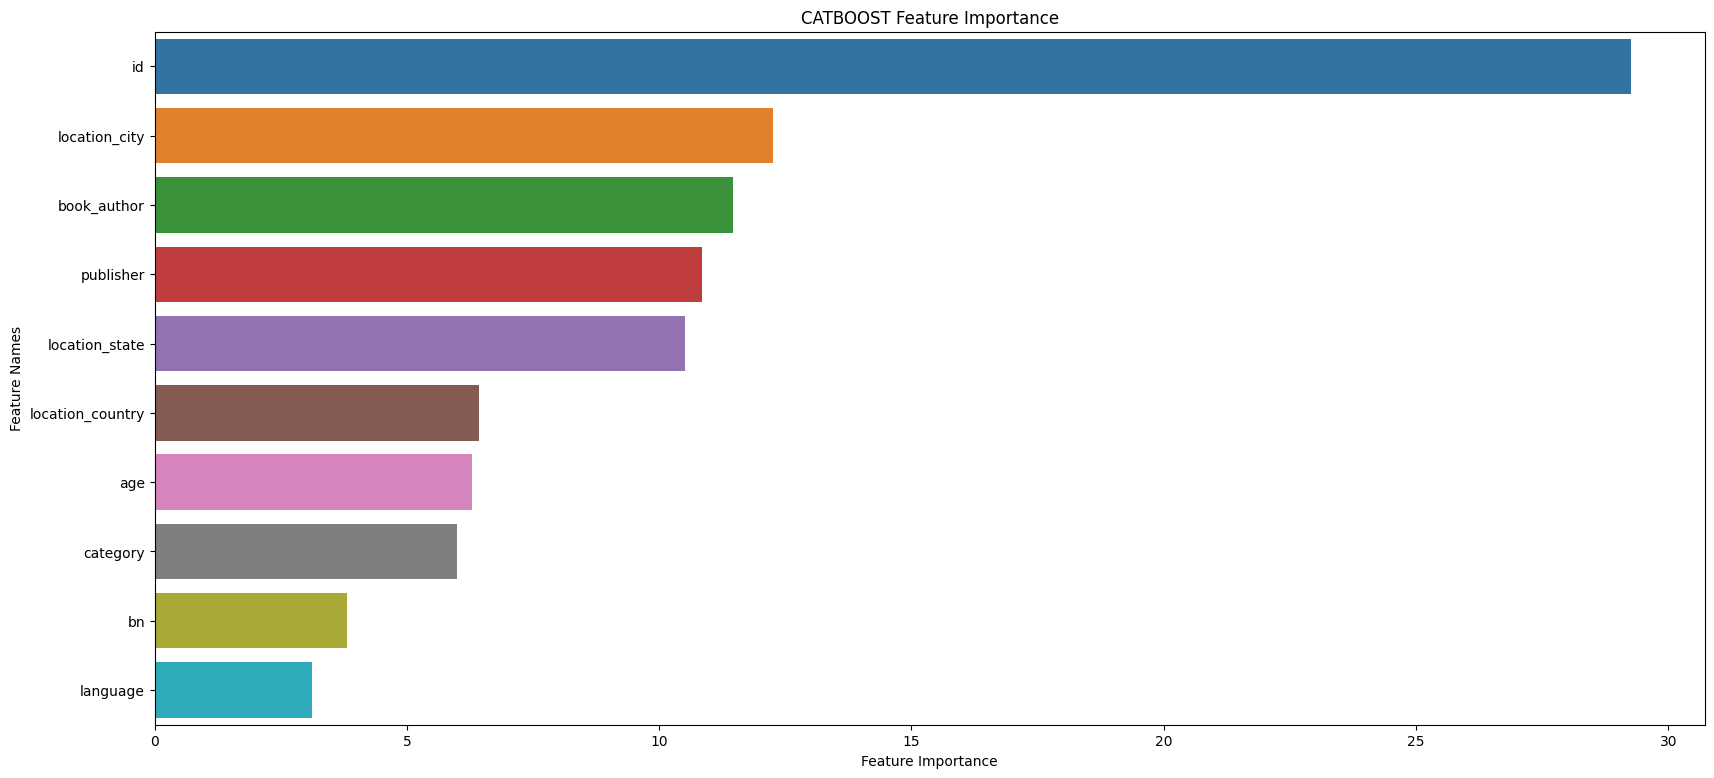

In [265]:
plot_feature_importance(cat.get_feature_importance(), test_df.drop(['user_id', 'isbn', 'rating'],axis = 1).columns, 'CATBOOST')

In [232]:
cat.get_feature_importance()

array([ 6.29577269, 12.26040543, 10.51794789,  6.42722237,  5.99895674,
       10.84526924,  3.12377887, 11.45774383, 29.2573957 ,  3.81550726])

In [235]:
train_df.drop(['user_id', 'isbn'], axis = 1).columns

Index(['rating', 'age', 'location_city', 'location_state', 'location_country',
       'category', 'publisher', 'language', 'book_author', 'id', 'bn'],
      dtype='object')

In [236]:
pip install sns

  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2664 sha256=5d90e88bbc6a7ce3bf2e1fb8bc985de2e140fb41d18ead65095e08892f8661b9
  Stored in directory: /opt/ml/.cache/pip/wheels/94/30/68/c7bbc5257894097a14adf5c7d6e7de56127c9936f27afe2416
Successfully built sns
Note: you may need to restart the kernel to use updated packages.


In [222]:
submit['rating'] = 0

In [223]:
for fold in range(5):
    submit['rating'] += cat_models[fold] / 5

In [225]:
import datetime
now = datetime.datetime.now()
created_time = now.strftime('%m%d-%H%M')

submit.to_csv(f'../data/{created_time}_submit.csv',index=False)

In [226]:
submit

,user_id,isbn,rating
0,11676,0002005018,7.005860
1,116866,0002005018,7.256630
2,152827,0060973129,7.553282
3,157969,0374157065,7.553738
4,67958,0399135782,7.303966
...,...,...,...
76694,278543,1576734218,6.169363
76695,278563,3492223710,6.288357
76696,278633,1896095186,6.311923
76697,278668,8408044079,5.132426
